In [4]:
import os 
import math
import datetime
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import layers
import tensorflow as tf

In [5]:
TRAIN_IMAGES_DIR = "train"
TRAIN_LABELS_FILE = "train_labels.csv"
# Reduce number of train images due to memory requirements
NB_TRAIN_IMAGES = 10000

Because of limited memory on laptop, the size of the training is limited instead of using the whole dataset.

In [7]:
%%time
dirname = TRAIN_IMAGES_DIR
train_images = []
train_images_id = []
for fname in os.listdir(dirname)[:NB_TRAIN_IMAGES]:
    train_images_id.append(fname.split(".tif")[0])
    im = Image.open(os.path.join(dirname, fname))
    imarray = np.array(im)
    train_images.append(imarray)

train_images = np.asarray(train_images)

CPU times: total: 5.38 s
Wall time: 33.5 s


In [8]:
original_train_labels = pd.read_csv(TRAIN_LABELS_FILE)

In [9]:
mapping = original_train_labels.set_index("id").T.to_dict()

In [10]:
train_labels = []
for id_ in train_images_id:
    train_labels.append(mapping[id_]["label"])
train_labels = np.asarray(train_labels)

We normalize the dataset such that the pixels have values between 0 and 1 instead of between 0 and 255.

In [11]:
def normalize_images(dataset):
    return np.asarray([d / 255.0 for d in dataset])

### Exploring Data Analysis

In [12]:
example_image = train_images[0]

In [13]:
# Image sizes (channels included)
print(example_image.shape)

(96, 96, 3)


The images are 96x96 pixels with 3 channels (R,G,B)

In [14]:
# Data range / pixel values
print("Min value: {}, max value: {}".format(example_image.min(), example_image.max()))

Min value: 0, max value: 255


The original pixel values are between 0 and 255, we normalize to  \[0;1\].

In [15]:
train_images = normalize_images(train_images)
example_image = train_images[0]
print("Min value: {}, max value: {}".format(example_image.min(), example_image.max()))

Min value: 0.0, max value: 1.0


In [16]:
# Label categories
print("Train labels: {}".format(np.unique(train_labels, return_counts=True)))

Train labels: (array([0, 1]), array([5936, 4064], dtype=int64))


We have two categories in the dataset: 0 and 1s, it is therefore a binary classification task.
In the small dataset we have extracted, we see that we have a good proportion of both categories. Having a balanced dataset reduces the risk of having a biased model.

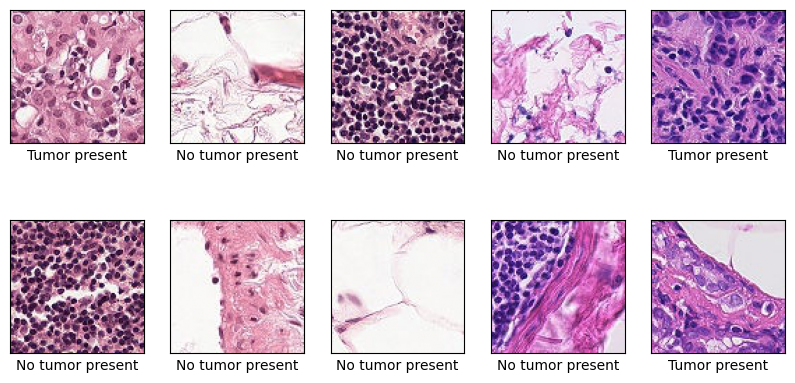

In [17]:
# Adapt, show some images
class_names = ['No tumor present', 'Tumor present']

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i]])
plt.show()

You can see above the depiction of the first 10 images of our training set with their label

### Model Building and Training

We build a model composed of two sequences (convolutional layer, convolutional layer, pooling) as follows:

In [18]:
model = keras.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3), padding="same"))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                   

In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

To save our progression during the training, we save the model at each epoch using callbacks

In [22]:
# Prepare Callback to save model regularly
modelname = datetime.datetime.now().strftime("Model_%Y%M%d_%H%M")
checkpoint_path = "models/" + modelname + "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)

We train the model on the first 10'000 images

In [23]:
%%time
history = model.fit(train_images, train_labels, epochs=10, callbacks=[cp_callback],
                    validation_split=0.1)

Epoch 1/10
282/282 [==============================] - ETA: 0s - loss: 0.6205 - accuracy: 0.6581
Epoch 1: saving model to models/Model_20244608_1346\cp-0001.ckpt
282/282 [==============================] - 114s 400ms/step - loss: 0.6205 - accuracy: 0.6581 - val_loss: 0.6200 - val_accuracy: 0.6170
Epoch 2/10
282/282 [==============================] - ETA: 0s - loss: 0.5673 - accuracy: 0.7086
Epoch 2: saving model to models/Model_20244608_1346\cp-0002.ckpt
282/282 [==============================] - 125s 445ms/step - loss: 0.5673 - accuracy: 0.7086 - val_loss: 0.5297 - val_accuracy: 0.7610
Epoch 3/10
282/282 [==============================] - ETA: 0s - loss: 0.5259 - accuracy: 0.7692
Epoch 3: saving model to models/Model_20244608_1346\cp-0003.ckpt
282/282 [==============================] - 127s 451ms/step - loss: 0.5259 - accuracy: 0.7692 - val_loss: 0.4990 - val_accuracy: 0.7890
Epoch 4/10
282/282 [==============================] - ETA: 0s - loss: 0.4971 - accuracy: 0.7817
Epoch 4: saving 

We plot the evolution of the accuracy and loss against the number of epochs

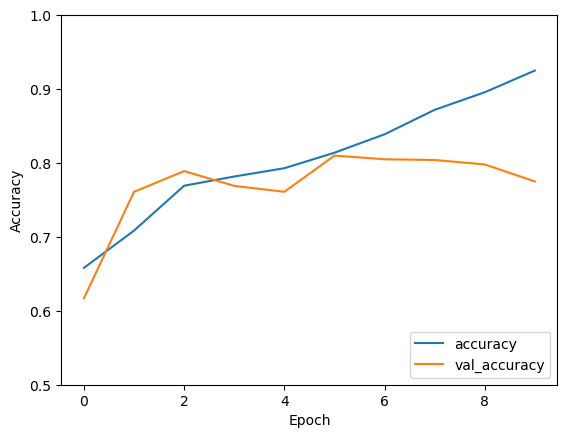

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

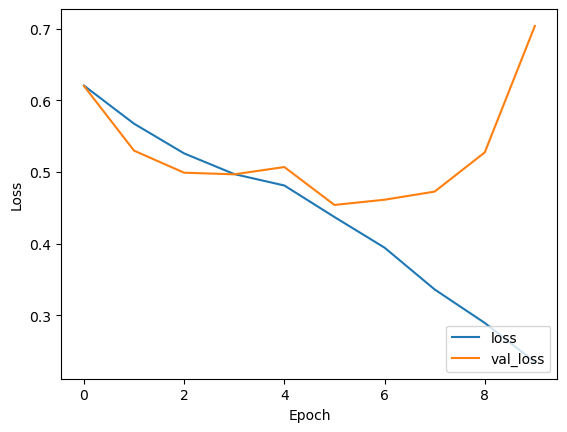

In [25]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

From the graphs, we can conclude that the model is slightly overfitting during the last epochs of the training as the training and validation loss and accuracy diverge.
This is expected as our training set is rather small.

### Evaluate Test Images

We prepare the submission of the test images, and obtain the test results from Kaggle.

In [26]:
TEST_IMAGES_DIR = "test"
FINAL_SUBMISSION_FILE = "final_submission.csv"

In [27]:
dirname = TEST_IMAGES_DIR
test_images = []
test_images_id = []
for fname in os.listdir(dirname):
    test_images_id.append(fname.split(".tif")[0])
    im = Image.open(os.path.join(dirname, fname))
    imarray = np.array(im)
    test_images.append(imarray)

test_images = np.asarray(test_images)

In [28]:
print(len(test_images))

57458


In [29]:
test_images = normalize_images(test_images)

In [30]:
%%time
# Evaluate test images with test set. Get result from Kaggle.
test_pred = model.predict(test_images)

1796/1796 [==============================] - 210s 117ms/step
CPU times: total: 8min 38s
Wall time: 4min 7s


In [31]:
test_pred_final = [0 if p < 0.5 else 1 for p in test_pred]

In [32]:
submission = pd.DataFrame({"id": test_images_id, "label": test_pred_final})

In [33]:
submission.to_csv(FINAL_SUBMISSION_FILE, index=False)

### Test Result

__First model (trained on 1'000 images and 10 epochs)__

Kaggle score when model is trained on 1000 images: 0.7287 (public) and 0.6343 (private)

Areas of improvement:
- Train longer (more epochs).
- More images to train on.

__Second model (trained on 10'000 images and 10 epochs)__

Kaggle score when model is trained on 10'000 images: 0.7799 (public) and 0.7429 (private)

### Discussion

Using only around 5% of the training dateset, we are able to reach around 75% accuracy on cancer detection on a baseline of 50%. Using more training data would yield significantly better results. 

Unfortunately, our computational power is not high enough to allow for this kind of processing.